# Binary Classifier w/ Embedding

This Notebook builds on from the previous example. It will demonstrate the traditional way of including historical information. I.e. Through feature engineering

---
#### Introduction
With the previous feedfoward neural nets, the neural net only saw a single payment, we could argue that this is not a lot to go by. Intuitively it is easy to understand that it might be important to have some historical back-ground on the card, the customer or the merchant. For instance; what is the average payment for this customer? Has this customer used this merchant before? Does this merchant use this MCC code a lot etc....

Traditionally this is where models use all sort of aggregate features. The information is grouped per entity and various stastics are drawn from the data. They are sometimes named profiles, or group features.

#### Note on the data set 
The data set used here (https://www.kaggle.com/ntnu-testimon/banksim1) is not particulary complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import datetime as dt
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define Base and derived features.
> In order to introduce grouped feature we will define features of type `FeatureGrouper`. Grouper features will group according to a certain feature and aggregate a feature. 

> Feature Groupers have following fields;
> - `Name`; The name of the feature
> - `Type` ; The type of the feature
> - `Base Feature`; this is the feature we want to aggregate, for instance the amount
> - `Group Feature`; the feature to group with. This is the entity on which we will calculate the aggregates, for instance on the customer.
> - `Filter Feature`; Optional filter expression. We could filter the data, for instance only international transactions.
> - `Time Period`; is the time period we want to use as base. Could be day, week or month
> - `Time Window`; the number of periods we want to aggregate. For instance 10.
> - `Aggregator`; aggregator function to apply. Can be; count, sum, max, min, mean, stddev


In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

## Define some basic grouper features and review the results.

In [4]:
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING) 
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT_32)

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

# Grouper Features
amount_cust_10d_sum = ft.FeatureGrouper(
    'amount_cust_10d_sum',               # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,            # Make the feature a type float
    amount,                              # Aggregate the amount
    customer,                            # Group over customer
    None,
    ft.TIME_PERIOD_DAY,                  # Make the period element a day
    10,                                  # Aggregate 10 days
    ft.AGGREGATOR_SUM                    # Take the sum over the period elements.
)

# This feature will return the 10 day sum of the amount, for the customer and a specific merchant.
amount_cust_10d_cnt = ft.FeatureGrouper(
    'amount_cust_10d_cnt',               # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,            # Make the feature a type float
    amount,                              # Aggregate the amount
    customer,                            # Group over customer/merchant
    None,
    ft.TIME_PERIOD_DAY,                  # Make the period element a day
    10,                                  # Aggregate 10 days
    ft.AGGREGATOR_COUNT                  # Take the sum over the period elements.
)

features = ft.TensorDefinition(
    'learning', 
    [
        customer,
        date_time,
        category,
        amount,
        amount_cust_10d_sum,
        amount_cust_10d_cnt
    ])


with en.EnginePandasNumpy(num_threads=8) as e:
    df_ft = e.from_csv(features, file, time_feature=date_time, inference=False)

# Filter out a specific customer, to get a feel for the grouping.
df_ft[df_ft['customer'] == 'C1753498738']

2022-05-18 20:47:31.630 d373c7.engines.common          INFO     Start Engine...
2022-05-18 20:47:31.631 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2022-05-18 20:47:31.631 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2022-05-18 20:47:31.631 d373c7.engines.panda_numpy     INFO     Building Panda for : learning from file ../../../../data/bs140513_032310.csv
2022-05-18 20:47:31.799 d373c7.engines.panda_numpy     INFO     Building Panda for : <Built Features> from DataFrame. Inference mode <False>
2022-05-18 20:47:31.799 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-05-18 20:47:31.805 d373c7.engines.panda_numpy     INFO     Done creating Built Features. Shape=(594643, 4)
2022-05-18 20:47:32.118 d373c7.engines.panda_numpy     INFO     Start creating aggregate grouper feature for <customer> using 8 process(es)
2022-05-18 20:47:40.857 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-0

,customer,date,category,amount,amount_cust_10d_sum,amount_cust_10d_cnt
1588,C1753498738,2020-01-01,es_transportation,20.860001,20.860001,1.0
2712,C1753498738,2020-01-02,es_transportation,11.700000,32.560001,2.0
7185,C1753498738,2020-01-03,es_transportation,6.500000,39.060001,3.0
8869,C1753498738,2020-01-04,es_hyper,82.059998,121.119995,4.0
12149,C1753498738,2020-01-05,es_health,24.190001,145.309998,5.0
...,...,...,...,...,...,...
577538,C1753498738,2020-06-24,es_transportation,11.330000,285.959991,10.0
580273,C1753498738,2020-06-25,es_transportation,14.410000,264.739990,10.0
586943,C1753498738,2020-06-26,es_transportation,29.920000,257.380005,10.0
587889,C1753498738,2020-06-27,es_transportation,10.940000,217.819992,10.0


### Now let's some grouper features the models can use.
We will add some `FeatureGrouper` features at both the customer and the merchant level and scale them

In [5]:
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING) 
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT_32)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)
date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)

# Grouper Features
# This calculates the 10 day sum of amounts for the customer
amount_cust_10d_sum = ft.FeatureGrouper(
    'amount_c_10d_sum',               # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,         # Make the feature a type float
    amount,                           # Aggregate the amount
    customer,                         # Group over customer
    None,
    ft.TIME_PERIOD_DAY,               # Make the period element a day
    10,                               # Aggregate 10 days
    ft.AGGREGATOR_SUM                 # Take the sum over the period elements.
)

# This calculates the 10 day count of amounts for the customer
amount_cust_10d_count = ft.FeatureGrouper(
    'amount_c_10d_count',             # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,         # Make the feature a type float
    amount,                           # Aggregate the amount
    customer,                         # Group over customer
    None,
    ft.TIME_PERIOD_DAY,               # Make the period element a day
    10,                               # Aggregate 10 days
    ft.AGGREGATOR_COUNT               # Take the count over the period elements.
)

# This calculates the 10 day max of amounts for the customer
amount_cust_10d_max = ft.FeatureGrouper(
    'amount_c_10d_max',               # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,         # Make the feature a type float
    amount,                           # Aggregate the amount
    customer,                         # Group over customer
    None,
    ft.TIME_PERIOD_DAY,               # Make the period element a day
    10,                               # Aggregate 10 days
    ft.AGGREGATOR_MAX                 # Take the maximum over the period elements.
)

# This calculates the 10 day min of amounts for the customer
amount_cust_10d_min = ft.FeatureGrouper(
    'amount_c_10d_min',               # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,         # Make the feature a type float
    amount,                           # Aggregate the amount
    customer,                         # Group over customer
    None,
    ft.TIME_PERIOD_DAY,               # Make the period element a day
    10,                               # Aggregate 10 days
    ft.AGGREGATOR_MIN                 # Take the minimum over the period elements.
)

# This calculates the 10 day average of amounts for the customer
amount_cust_10d_avg = ft.FeatureGrouper(
    'amount_c_10d_avg',               # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,         # Make the feature a type float
    amount,                           # Aggregate the amount
    customer,                         # Group over customer
    None,
    ft.TIME_PERIOD_DAY,               # Make the period element a day
    10,                               # Aggregate 10 days
    ft.AGGREGATOR_AVG                 # Take the average over the period elements.
)

amount_cust_10d_sum_s = ft.FeatureNormalizeScale(
    'amount_c_10d_sum_s', ft.FEATURE_TYPE_FLOAT_32, amount_cust_10d_sum
)

amount_cust_10d_count_s = ft.FeatureNormalizeScale(
    'amount_c_10d_count_s', ft.FEATURE_TYPE_FLOAT_32, amount_cust_10d_count
)

amount_cust_10d_max_s = ft.FeatureNormalizeScale(
    'amount_c_10d_max_s', ft.FEATURE_TYPE_FLOAT_32, amount_cust_10d_max
)

amount_cust_10d_min_s = ft.FeatureNormalizeScale(
    'amount_c_10d_min_s', ft.FEATURE_TYPE_FLOAT_32, amount_cust_10d_min
)

amount_cust_10d_avg_s = ft.FeatureNormalizeScale(
    'amount_c_10d_avg_s', ft.FEATURE_TYPE_FLOAT_32, amount_cust_10d_avg
)

fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

features = ft.TensorDefinition(
    'learning', 
    [
        age_i,
        gender_i,
        merchant_i,
        category_i,
        amount,
        amount_cust_10d_sum_s,
        amount_cust_10d_count_s,
        amount_cust_10d_avg_s,
        amount_cust_10d_min_s, 
        amount_cust_10d_max_s
    ])

label = ft.TensorDefinition('label', [fraud_label])

model_features = ft.TensorDefinitionMulti([features, label])

with en.EnginePandasNumpy(num_threads=8) as e:
    df_ft = e.from_csv(features, file, time_feature=date_time, inference=False)
    df_lb = e.from_csv(label, file, inference=False)

2022-05-18 20:47:56.791 d373c7.engines.common          INFO     Start Engine...
2022-05-18 20:47:56.791 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2022-05-18 20:47:56.791 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2022-05-18 20:47:56.792 d373c7.engines.panda_numpy     INFO     Building Panda for : learning from file ../../../../data/bs140513_032310.csv
2022-05-18 20:47:56.995 d373c7.engines.panda_numpy     INFO     Building Panda for : <Built Features> from DataFrame. Inference mode <False>
2022-05-18 20:47:56.996 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-05-18 20:47:57.002 d373c7.engines.panda_numpy     INFO     Done creating Built Features. Shape=(594643, 7)
2022-05-18 20:47:57.336 d373c7.engines.panda_numpy     INFO     Start creating aggregate grouper feature for <customer> using 8 process(es)
2022-05-18 20:48:10.632 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-0

## Convert to Numpy
After converting the panda DataFrame to numpy lists per learning type, we have a first list with 6 continous features (the amount and our 6 aggregate FeatureGroupers), a second with 4 categorical features (the `FeatureIndex` features) and the last list contains the label

In [6]:
with en.EnginePandasNumpy() as e:
    ft_np = e.to_numpy_list(features, df_ft)
    lb_np = e.to_numpy_list(label, df_lb)

data_list = en.NumpyList(ft_np.lists + lb_np.lists)

print(data_list.shapes)
print(data_list.dtype_names)

2022-05-18 20:48:14.112 d373c7.engines.common          INFO     Start Engine...
2022-05-18 20:48:14.113 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2022-05-18 20:48:14.113 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2022-05-18 20:48:14.113 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: float32
2022-05-18 20:48:14.114 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Continuous
2022-05-18 20:48:14.116 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int16
2022-05-18 20:48:14.116 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Categorical
2022-05-18 20:48:14.119 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2022-05-18 20:48:14.119 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Label


[(594643, 6), (594643, 4), (594643,)]
['float32', 'int16', 'int8']


## Wrangle the data
Time split the data. For time series data it is very important to keep the order of the data. This split will start from the end and work it's way to the front of the data. This way the training, validation and test data are nicely colocated in time

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

Because we have grouper features, we'll perform an additional action.
> 1. The aggregates at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history , sometimes named 'mature' aggregates. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [7]:
test_records = 100000
val_records  = 30000 
maturation   = 30000

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del df_ft, df_lb
del ft_np, lb_np
del data_list

gc.collect()
print('Done')

Training Data shapes [(434643, 6), (434643, 4), (434643,)]
Validation Data shapes [(30000, 6), (30000, 4), (30000,)]
Test Data shapes [(100000, 6), (100000, 4), (100000,)]
Done


## Set-up Devices

In [8]:
device, cpu = pt.init_devices()

2022-05-18 20:48:40.806 d373c7.pytorch.common          INFO     Torch Version : 1.11.0+cu113
2022-05-18 20:48:40.838 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2022-05-18 20:48:40.839 d373c7.pytorch.common          INFO     Cuda Version  : 11.3


# Define Model


The training data set has to be balanced for Neural Nets. To do this, the fraud class will be aggressively upsampled in the training phase by a custom `ClassSampler`. It oversamples the minority label until it matches the majority label. This may not be a good idea for a really large data sets.

> 1. First set-up a NumpyListDataSet for both the training data-set and validation data-set. A NumpyListDataSet is a specialised `Pytorch Dataset` which keeps the data as numpy arrays in memory and converts on the fly to `Pytorch Tensors`
> 2. Set-up a sampler for the training set only. The sampler will over-sample the '1'/fraud class. Note that this means the training and validation set are balanced *differently*. This is important when interpreting the plots.
> 3. Wrap the dataset in a Pytorch Dataloader. `Dataloaders` allow the training loop to iterate over 'batches' of the `Datasets`
> 4. Create a model. Here the most basic `GeneratedClassifier` is used. The GeneratedClassifier will create a model using the information it has about the features. *We are defining it to have 1 hidden layer of size 16*.  The last layer is a single number, it had a sigmoid applied to it so we can more or less interpret this as a 'probability of fraud'. We use Binary Crossentropy loss.


In [9]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(model_features, train_data)
val_ds = pt.NumpyListDataSetMulti(model_features, val_data)
train_sampler = pt.ClassSamplerMulti(model_features, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a Model
m = pm.GeneratedClassifier(model_features, linear_layers=[16])
print(m)

GeneratedClassifier(
  Number of parameters : 2244. Loss : SingleLabelBCELoss,  mean
  (streams): ModuleList(
    (0): TensorDefinitionHead(
      lcs=['Continuous', 'Categorical']
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(9, 4)
          (1): Embedding(5, 4)
          (2): Embedding(51, 25)
          (3): Embedding(16, 7)
        )
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (tail): TailBinary(
    (layers): Sequential(
      (tail_lin_01): Linear(in_features=46, out_features=16, bias=True)
      (tail_act_01): ReLU()
      (tail_dropout_01): Dropout(p=0.1, inplace=False)
      (tail_batch_norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (tail_binary): Linear(in_features=16, out_features=1, bias=True)
      (tail_bin_act): Sigmoid()
    )
  )
)


# Start training

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr funtion and plot. This function iterates over the batches, gradually increasing the learning rate from a minimum to a maximum learning rate. It tends to show where we can find a good learning rate.

2022-05-18 20:48:43.769 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 369.45it/s]
2022-05-18 20:48:46.364 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


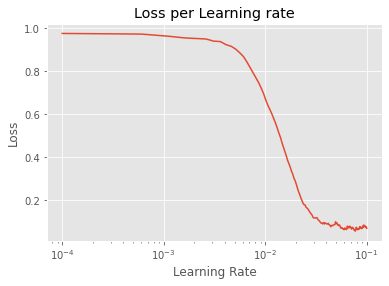

In [10]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. We see the model behaves fairly well during training. The loss goes up slightly in the middle of the training. This is the one_cycle logic which is reaching the max learning rate. 

Epoch 010/010: 100%|██████████| 3631/3631 [00:05<00:00, 694.47it/s, train_loss=0.0454, train_acc=0.983, val_loss=0.0334, val_acc=0.986]


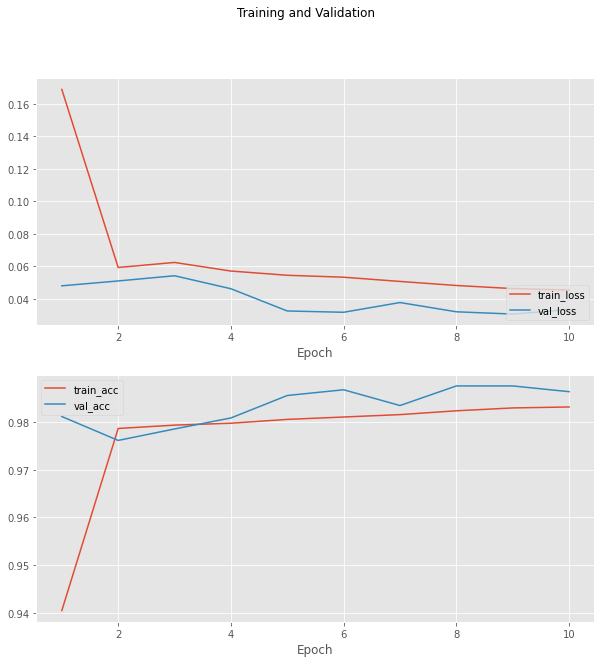

In [11]:
t = pt.Trainer(m, cpu, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data
> Test the model on the test set. This model behaves fairly OK and as we expected. Contrary to what the AUC score would leave us to believe this model creates significanly less false positives. We would be lead to believe that the general intuition, that providing some form of history helps the model, is correct. 

Testing in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 924.93it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     98926
         1.0       0.48      0.98      0.64      1074

    accuracy                           0.99    100000
   macro avg       0.74      0.98      0.82    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9991
ap score  : 0.9426
-----------------------------------------------------


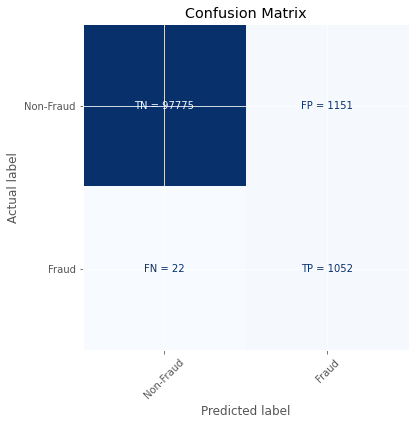

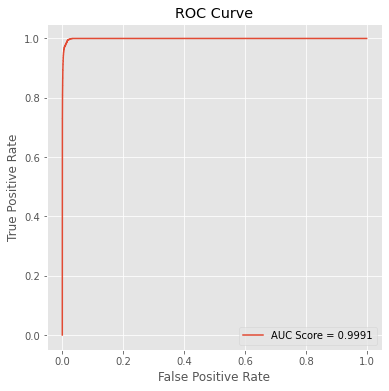

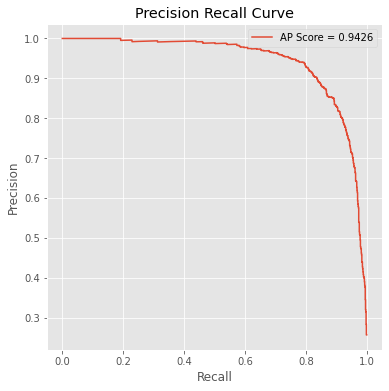

In [12]:
test_ds = pt.NumpyListDataSetMulti(model_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

## Plot Embeddings
We can make the observation that the 'es_leisure' is much less of an outlier in this embedding. The explained variance is more distributed across the dimensions. These embedding describe different aspects than the previous example. Detail analysis would be needed to see what exactly and if this is a potenial reason for the reduced False Positive count.

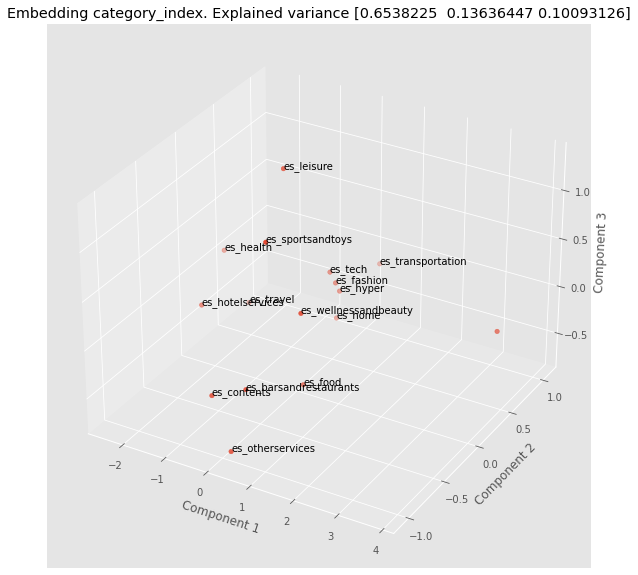

In [13]:
w = m.embedding_weight(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, dims=3, fig_size=(10,10))

# Conclusion
After this notebook we suspect that providing customer history to a model (in the form of grouper/profile feature) helps the model. 
In a real-life situation we would for sure use longer running features. I.e. where the timewindow and period are longer. These are too short running really. We could add `FeatureGrouper` features on merchant and maybe category. Equally we could consider adding `FeatureGrouper` features on the relation between a customer and a merchant. 
But figuring out the exact features to use is not so easy if we are uncertain of the type of Fraud and the characteristics.
This example will give us a base line to see if the series in the next set of examples are better or worse than this 'traditional' approach of 'Feature Engineering'